# Importing required libraries

In [1]:
import pandas as pd
import cv2
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
dir = "dataset/"

# Proposed method

Synthesising artificial multiple exposure image of the base ground truth image using gamma transformation 

In [3]:
def gamma_trans(img, gamma):
    gamma_table=[np.power(x/255.0,gamma)*255.0 for x in range(256)]
    gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
    return cv2.LUT(img,gamma_table)

This load image exposure function returns the specific channel(given as argument) of the image in multiple exposures(Using gamma_trans()).


Arguments: image, channel <br>
returns: array of images, array of exposure times

In [4]:
def load_image_exposure(image, channel):
    times = np.array([ 1/5, 1/3, 4, 7 ], dtype=np.float32)
    images = []
    
    for time in times:
        temp = np.zeros((image.shape[0],image.shape[1]), dtype='uint8')
        temp[:,:] = gamma_trans(image, time)[:, :, channel]
        images.append(temp)

    return images, times

This load image exposure function returns the image in multiple exposures(Using gamma_trans()).



Arguments: image <br>
returns: array of images, array of exposure times

In [5]:
def load_image_exposure_single_channel(image):
    times = np.array([ 1/5, 1/3, 3, 5 ], dtype=np.float32)
    images = []
    
    for time in times:
        images.append(gamma_trans(image, time))

    return images, times

In [6]:
def get_pixel_samples(test_image, save_samples=True):
    pixel_samples = []
    x = []
    y = []
    num_samples = 100
    image_size = test_image.shape[0] * test_image.shape[1]

    while len(pixel_samples) < num_samples:
        i = random.randint(0, image_size - 1)
        pixel_samples.append(i)
        x.append(i / test_image.shape[0])
        y.append(i % test_image.shape[0])

    return pixel_samples


In [7]:
def sample_pixel_values(images, samples):
    z = []
    for img in images:
        tmp = list()
        for i in samples:
            tmp.append(img[int(i % img.shape[0]), int(i / img.shape[0])])
        z.append(tmp)
    return z

## Compute response curve

Formulae for computing response curve:

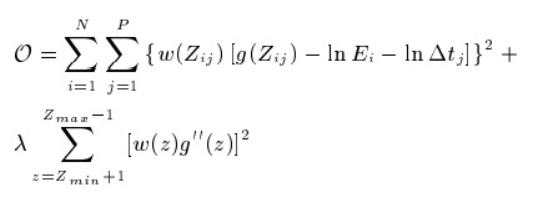

In [8]:

def compute_response_curve(Z, B, w):
    z_max = 256
    L= 50

    # Number of images
    p = np.size(Z, 0)

    # Number of samples
    n = np.size(Z, 1)

    A = np.zeros(shape=(n * p + z_max + 1, z_max + n), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(n):
        for j in range(p):
            z = Z[j][i]
            wij = w[z]
            A[k][z] = wij
            A[k][z_max + i] = -wij
            b[k] = wij * B[j]
            k += 1

    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(z_max - 1):
        A[k][i] = L * w[i + 1]
        A[k][i + 1] = -2 * L * w[i + 1]
        A[k][i + 2] = L * w[i + 1]
        k += 1

    # Solve the system using SVD
    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[0:z_max]
    lE = x[z_max:np.size(x, 0)]

    return g


## Compute radiance map

Formulae for calculating radiance map:

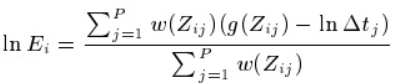

In [9]:

def create_radiance_map(img_list, g, B, w):
    img_shape = img_list[0].shape
    img_rad_map = np.zeros(img_shape, dtype=np.float64)

    num_images = len(img_list)
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):

            gz = list()
            wz = list()

            for k in range(0, num_images):
                gz.append(g[img_list[k][i, j]][0])
                wz.append(w[img_list[k][i, j]])

            gz = np.asarray(gz)
            wz = np.asarray(wz)

            sum_w = np.sum(wz)
            if sum_w > 0:
                img_rad_map[i, j] = np.sum(wz * (gz - B) / sum_w)
            else:
                img_rad_map[i, j] = gz[num_images // 2] - B[num_images // 2]
    return img_rad_map


All 3 channels of the image are concatinated at the last

In [10]:
def concat_images(imga, imgb):
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    
    imga = imga/255;
    
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    
    return new_img


# Main function

This function call performs the 

In [11]:
def make_HDR_Image(image, path):
    image_list_b, times = load_image_exposure(img2 , channel=0)
    image_list_g, _ = load_image_exposure(img2, channel=1)
    image_list_r, _ = load_image_exposure(img2, channel=2)

    samples = get_pixel_samples(test_image=img2, save_samples=True)
    
    w = [z if z <= 0.5 * 255 else 255 - z for z in range(256)]

    B = [math.log(e) for e in times]
    
    z_blue = sample_pixel_values(images=image_list_b, samples=samples)
    z_green = sample_pixel_values(images=image_list_g, samples=samples)
    z_red = sample_pixel_values(images=image_list_r, samples=samples)

    response_curve_b = compute_response_curve(z_blue, B, w)
    response_curve_g = compute_response_curve(z_green, B, w)
    response_curve_r = compute_response_curve(z_red, B, w)

    shape = image.shape
    width = shape[1]
    height = shape[0]

    E_b = create_radiance_map(image_list_b, response_curve_b, B, w)
    E_g = create_radiance_map(image_list_g, response_curve_g, B, w)
    E_r = create_radiance_map(image_list_r, response_curve_r, B, w)
            
    hdr = np.zeros(shape, 'float32')
    hdr[..., 0] = np.reshape(np.exp(E_b), (height, width))
    hdr[..., 1] = np.reshape(np.exp(E_g), (height, width))
    hdr[..., 2] = np.reshape(np.exp(E_r), (height, width))

    normalize = lambda zi: (zi - zi.min() / zi.max() - zi.min())

    z_disp = normalize(np.log(hdr))

    hdrImage = ((1-(z_disp / z_disp.max()))*255).astype(np.uint8)

#     Histogram equalization
    R, G, B = cv2.split(hdrImage)

    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)

    equ = cv2.merge((output1_R, output1_G, output1_B))
    
#         
    equ = cv2.cvtColor(equ, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    output = concat_images(image, equ/255)
    
    cv2.imwrite("screenshots/"+path, (output*255).astype(np.uint8))
    
#####################################

    img_list, exposure_times = load_image_different_exposure(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        
#     outputs of other methods

    calibrate_debevec = cv2.createCalibrateDebevec()
    hdr_calibrate = calibrate_debevec.process(img_list, exposure_times)

    merge_debevec = cv2.createMergeDebevec()
    hdr_debevec = merge_debevec.process(img_list, exposure_times.copy(), hdr_calibrate)

    merge_robertson = cv2.createMergeRobertson()
    hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy())

    tonemap1 = cv2.createTonemap(gamma=2.2)
    res_debevec = tonemap1.process(hdr_debevec.copy())

    merge_mertens = cv2.createMergeMertens()
    res_mertens = merge_mertens.process(img_list)
    
#     res_mertens = ((res_mertens/res_mertens.max())
#     res_mertens = ((res_mertens/res_mertens.max())*255).astype(np.uint8)
    
#     R, G, B = cv2.split(res_mertens)

#     output1_R = cv2.equalizeHist(R)
#     output1_G = cv2.equalizeHist(G)
#     output1_B = cv2.equalizeHist(B)

#     res_mertens = cv2.merge((output1_R, output1_G, output1_B))
    
    
#     Printing it all in pattern
    

    fig = plt.figure(figsize=(60, 40))
    gs = GridSpec(4, 4, figure=fig)
    
    
    for i in range(len(img_list)):
        fig.add_subplot(gs[0, i])
        plt.imshow(img_list[i])
        plt.title("Gamma = "+ str(exposure_times[i]))
        
    
    fig.add_subplot(gs[1,0])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original image (Ground truth)")
    
    fig.add_subplot(gs[1,1:])
    plt.title("HIstogramm for given Image'  ")
    plt.xlabel("Value")
    plt.ylabel("pixels Frequency")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.hist(gray)

    fig.add_subplot(gs[2,0])
    plt.imshow(hdr_debevec)
    plt.title("HDR image (Debevec)")
    
    fig.add_subplot(gs[2,1])
    plt.imshow(res_debevec)
    plt.title("HDR image (Debevec + tonemapping)")
    
    fig.add_subplot(gs[2,2])
    plt.imshow(hdr_robertson)
    plt.title("HDR image (Robinston)")
    
    fig.add_subplot(gs[2,3])
    plt.imshow(res_mertens)
    plt.title("HDR image (mertens merge)")
    
    
    fig.add_subplot(gs[3,0])
    plt.imshow(cv2.cvtColor(equ, cv2.COLOR_BGR2RGB))
    plt.title("HDR image (Proposed method)")
    
    fig.add_subplot(gs[3,1:])
    plt.title("HIstogramm for given Image'  ")
    plt.xlabel("Value")
    plt.ylabel("pixels Frequency")
    gray = cv2.cvtColor(equ, cv2.COLOR_BGR2GRAY)
    plt.hist(gray)
    
   
    

# Induvidual image

In [34]:
img = cv2.imread("dataset/6G7M_20150410_063210_560.jpg", cv2.IMREAD_COLOR )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img ,(500,600))

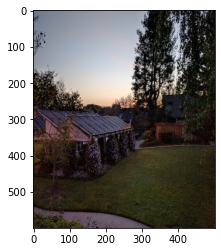

In [35]:
plt.imshow(img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


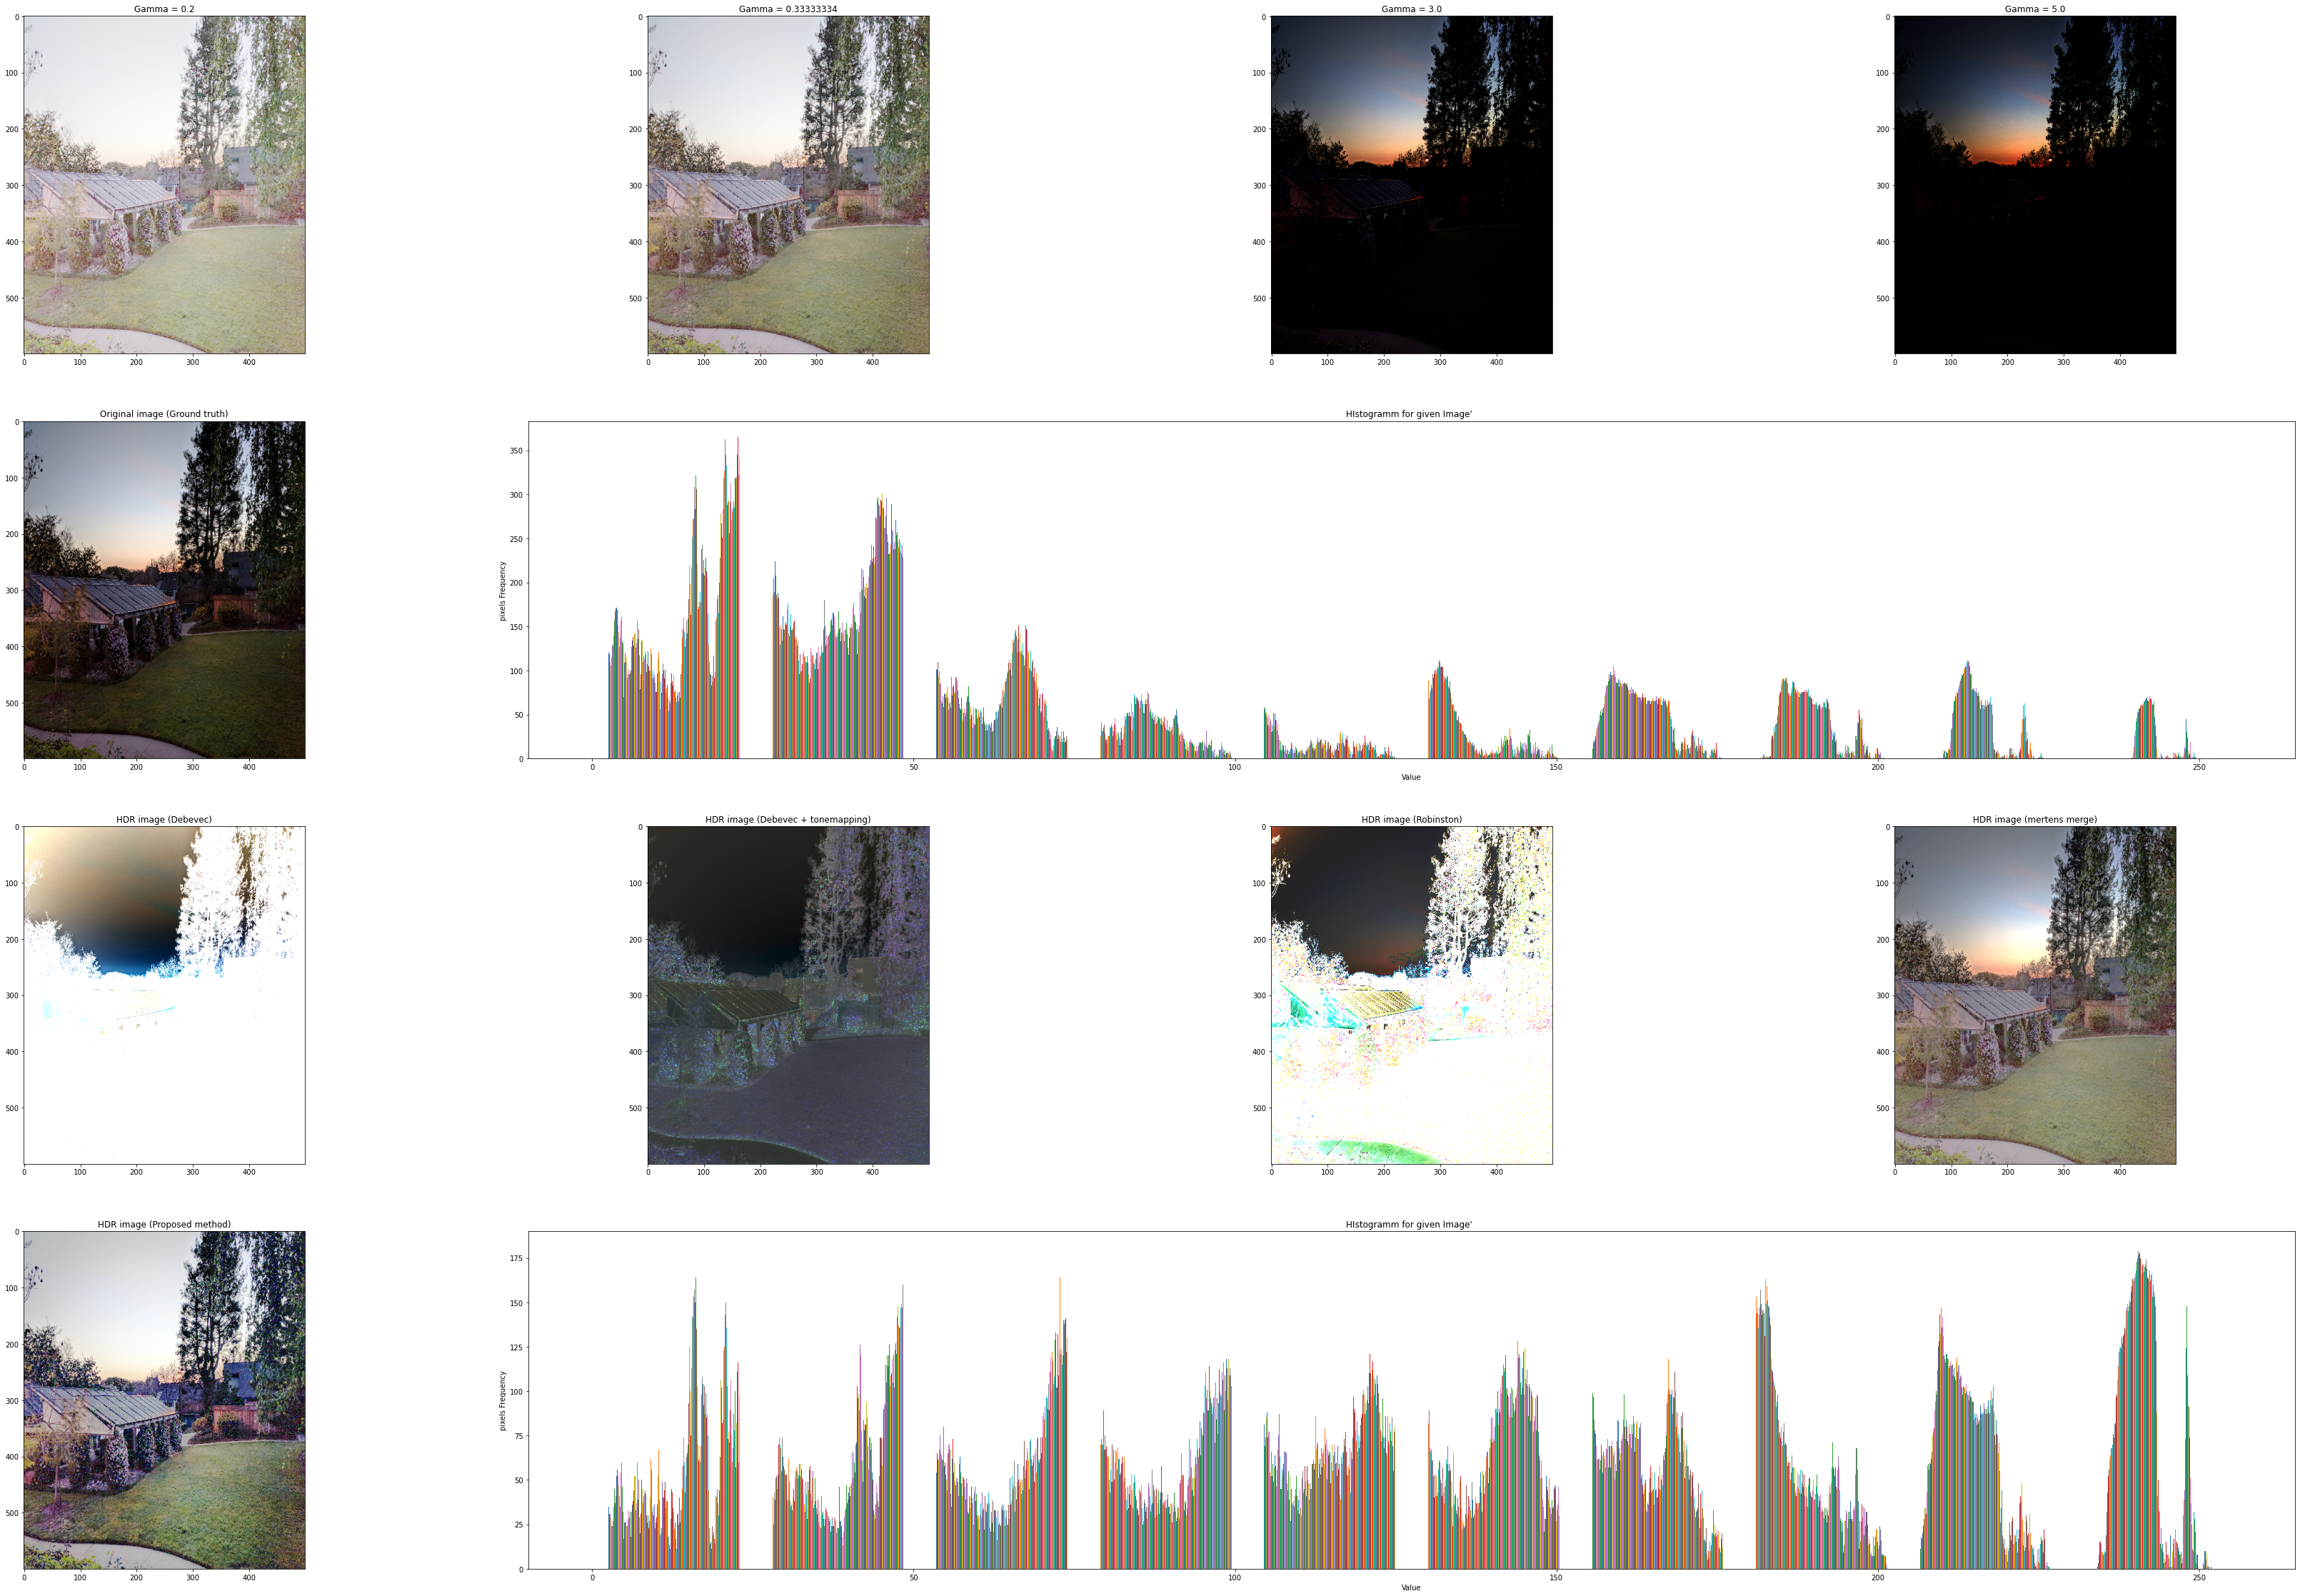

In [44]:
make_HDR_Image(img2, "6G7M_20150410_063210_560.jpg")

In [305]:
extensions = os.listdir(dir)

for extension in extensions:
    if extension.endswith(".jpg"):
        img = cv2.imread(dir + extension, cv2.IMREAD_COLOR )
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img ,(600,400))
        make_HDR_Image(img, extension)

KeyboardInterrupt: 

# Other methods

In [37]:
img_list, exposure_times = load_image_different_exposure(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [72]:
calibrate_debevec = cv2.createCalibrateDebevec()
hdr_calibrate = calibrate_debevec.process(img_list, exposure_times)

merge_debevec = cv2.createMergeDebevec()
hdr_debevec = merge_debevec.process(img_list, exposure_times.copy(), hdr_calibrate)
    
merge_robertson = cv2.createMergeRobertson()
hdr_robertson = merge_robertson.process(img_list, times=exposure_times.copy())

tonemap1 = cv2.createTonemapDrago(1.0, 0.7)
res_debevec = tonemap1.process(hdr_debevec)
res_debevec = 3 * res_debevec;

merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(img_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float32


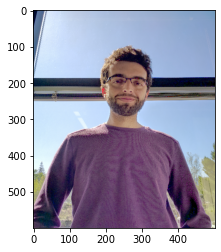

In [73]:
print(res_debevec.dtype)
plt.imshow(cv2.cvtColor(1-res_debevec, cv2.COLOR_BGR2RGB))

uint8


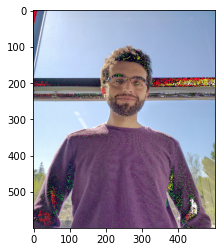

In [74]:
res_debevec = cv2.cvtColor(((1-res_debevec)*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(res_debevec)
print(res_debevec.dtype)

In [ ]:
output = concat_images(res_debevec, equ/255)
    
cv2.imwrite("screenshots/"+path+"2.jpg", (output*255).astype(np.uint8))

In [57]:
res_debevec.dtype

dtype('uint8')

# To work with

In [58]:
img = cv2.imread("dataset/6G7M_20150325_113420_008.jpg", cv2.IMREAD_COLOR )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img ,(500,600))

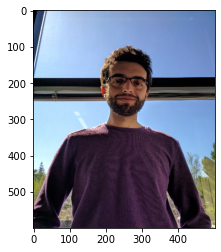

In [59]:
plt.imshow(img2)

In [48]:
R, G, B = cv2.split(img2)

In [19]:
image_list_r, times = load_image_exposure(img2, 0)
image_list_g, _ = load_image_exposure(img2, 1)
image_list_b, _ = load_image_exposure(img2, 2)

samples = get_pixel_samples(test_image=img2, save_samples=True)
    

In [20]:
fig = plt.figure(figsize=(60, 40))
rows = 3
columns = 2

for i in range(len(image_list_r)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image_list_r[i])

In [21]:
# plt.imshow(image_list_r[3])
image_list_r[3].shape

(600, 500)

In [22]:
w = [z if z <= 0.5 * 255 else 255 - z for z in range(256)]

B = [math.log(e) for e in times]

In [23]:
z_blue = sample_pixel_values(images=image_list_b, samples=samples)
z_green = sample_pixel_values(images=image_list_g, samples=samples)
z_red = sample_pixel_values(images=image_list_r, samples=samples)

response_curve_b = compute_response_curve(z_blue, B, w)
response_curve_g = compute_response_curve(z_green, B, w)
response_curve_r = compute_response_curve(z_red, B, w)

plt.figure()
plt.plot(response_curve_b, range(256), 'b')
plt.plot(response_curve_g, range(256), 'g')
plt.plot(response_curve_r, range(256), 'r')
plt.ylabel('pixel value Z')
plt.xlabel('log exposure X')

Text(0.5, 0, 'log exposure X')

In [24]:
shape = img2.shape
width = shape[1]
height = shape[0]

E_b = create_radiance_map(image_list_b, response_curve_b, B, w)
E_g = create_radiance_map(image_list_g, response_curve_g, B, w)
E_r = create_radiance_map(image_list_r, response_curve_r, B, w)


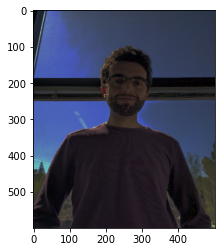

In [26]:

hdr = np.zeros(shape, 'float32')
hdr[..., 0] = np.reshape(np.exp(E_r), (height, width))
hdr[..., 1] = np.reshape(np.exp(E_g), (height, width))
hdr[..., 2] = np.reshape(np.exp(E_b), (height, width))

normalize = lambda zi: (zi - zi.min() / zi.max() - zi.min())

z_disp = normalize(np.log(hdr))

hdrImage = ((1-(z_disp / z_disp.max()))*255).astype(np.uint8)

plt.imshow(hdrImage)

In [44]:
(z_disp/z_disp.max()).min()

0.25266463

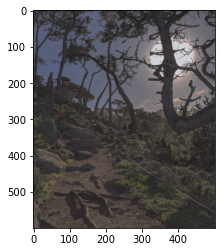

In [45]:
plt.imshow((1.1-(z_disp/z_disp.max())))

uint8


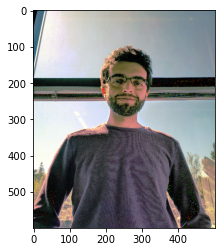

In [27]:
R, G, B = cv2.split(hdrImage)

output1_R = cv2.equalizeHist(R)
output1_G = cv2.equalizeHist(G)
output1_B = cv2.equalizeHist(B)

equ = cv2.merge((output1_R, output1_G, output1_B))

plt.imshow(equ)
print(equ.dtype)

In [28]:
plt.title("HIstogramm for given Image'  ")
plt.xlabel("Value")
plt.ylabel("pixels Frequency")
gray = cv2.cvtColor(equ, cv2.COLOR_BGR2GRAY)
plt.hist(gray)

(array([[ 91.,  22.,  14., ...,   8.,  11., 197.],
        [101.,  14.,  11., ...,   6.,  11., 198.],
        [ 93.,  19.,  11., ...,  13.,   8., 198.],
        ...,
        [ 29.,   3.,   0., ...,  47.,   7.,   2.],
        [ 29.,   4.,   2., ...,  45.,   6.,   2.],
        [ 30.,   1.,   3., ...,  39.,   7.,   3.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 500 BarContainer objects>)

(array([[110.,  23., 111., ...,   7.,  72., 137.],
        [114.,  19., 103., ...,   4.,  72., 136.],
        [112.,  16., 102., ...,   7.,  62., 144.],
        ...,
        [ 33.,   4.,  21., ...,  45.,   3.,   4.],
        [ 33.,   3.,  24., ...,  40.,   3.,   5.],
        [ 33.,   5.,  23., ...,  35.,   6.,   4.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 500 BarContainer objects>)

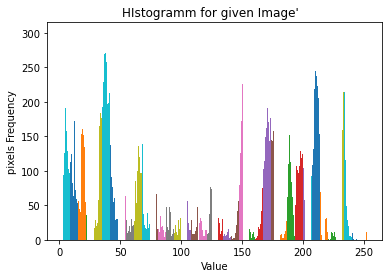

In [29]:
plt.title("HIstogramm for given Image'  ")
plt.xlabel("Value")
plt.ylabel("pixels Frequency")
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.hist(gray)

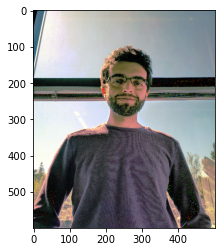

In [31]:
plt.imshow(equ)
equ = cv2.cvtColor(equ, cv2.COLOR_RGB2BGR)
# cv2.imwrite("output/eq.jpg", equ)

In [30]:
equ.dtype

dtype('uint8')

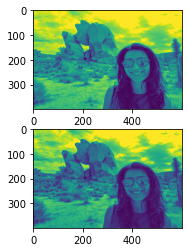

In [154]:
fig = plt.subplots(2,1)

plt.subplot(2,1,1);
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY))

plt.subplot(2,1,2);
plt.imshow(cv2.cvtColor(equ, cv2.COLOR_RGB2GRAY))

True

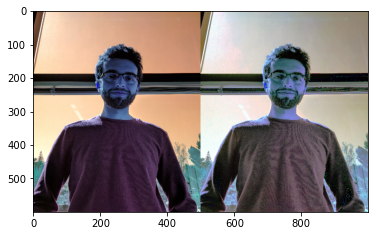

In [33]:
equ = cv2.cvtColor(equ, cv2.COLOR_RGB2BGR)
# img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

op = concat_images(img2, equ/255)
plt.imshow(op)

cv2.imwrite("output/op.jpg", (op*255).astype(np.uint8))

dtype('uint8')

# Another one

In [15]:
def load_image_different_exposure(image):
    times = np.array([ 1/5, 1/3, 3, 5 ], dtype=np.float32)
    images = []
    
    for time in times:
        images.append(gamma_trans(image, time))

    return images, times

In [17]:
images, times = load_image_different_exposure(img2)
outputs = computeHDR(images, times)

In [18]:
plt.imshow(outputs)

NameError: name 'outputs' is not defined

In [52]:

calibrate = cv2.createCalibrateDebevec()
response = calibrate.process(images, times)
merge_debevec = cv2.createMergeDebevec()
hdr = merge_debevec.process(images, times, response)

tonemap = cv2.createTonemap(2.2)
ldr = tonemap.process(hdr)


merge_mertens = cv2.createMergeMertens()
fusion = merge_mertens.process(images)
plt.imshow(fusion )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


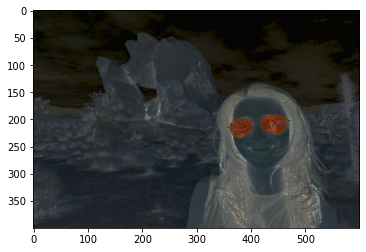

In [62]:
plt.imshow(ldr)

In [58]:
plt.imshow(img2)